              precision    recall  f1-score   support

        bike       0.64      0.56      0.60        25
         car       0.61      0.68      0.64        25

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.62      0.62      0.62        50



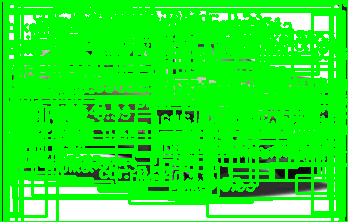

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import models, transforms
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from PIL import Image
from google.colab.patches import cv2_imshow


# Step 1: Load the pre-trained CNN model (e.g., VGG16)
cnn_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
cnn_model.eval()

# Step 2: Initialize Selective Search for region proposals
def generate_region_proposals(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()  # Use fast mode
    rects = ss.process()[:200]  # Limit to top 200 proposals
    return rects

# Step 3: Extract features from each region proposal
def extract_features(image, rects, transform, cnn_model):
    features = []
    regions = []
    for x, y, w, h in rects:
        roi = image[y:y+h, x:x+w]
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)  # Convert to RGB
        roi_pil = Image.fromarray(roi_rgb)  # Convert to PIL Image
        roi_tensor = transform(roi_pil).unsqueeze(0)  # Apply transformations
        with torch.no_grad():
            feature = cnn_model.features(roi_tensor).squeeze().numpy()
        features.append(feature.flatten())
        regions.append((x, y, w, h))
    return np.array(features), regions

# Step 4: Train a classifier (e.g., SVM) on region features
def train_classifier(features, labels):
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    classifier = SVC(kernel='linear', probability=True)
    classifier.fit(features, labels_encoded)
    return classifier, le

# Step 5: Object detection pipeline
def detect_objects(image, classifier, label_encoder, rects, features, confidence_threshold=0.5):
    predictions = classifier.predict_proba(features)
    results = []
    for i, probs in enumerate(predictions):
        confidence = np.max(probs)
        if confidence > confidence_threshold:
            label = label_encoder.inverse_transform([np.argmax(probs)])[0]
            x, y, w, h = rects[i]
            results.append((label, confidence, (x, y, w, h)))
    return results

# Main pipeline
def rcnn_pipeline(image_path, labels, transform):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    rects = generate_region_proposals(image)
    features, regions = extract_features(image, rects, transform, cnn_model)

    # Split data for simplicity (use a proper dataset in real scenarios)
    train_features = features[:150]
    test_features = features[150:]
    train_labels = labels[:150]
    test_labels = labels[150:]

    # Train classifier
    classifier, label_encoder = train_classifier(train_features, train_labels)

    # Evaluate on test data
    predictions = classifier.predict(test_features)
    test_labels_encoded = label_encoder.transform(test_labels)
    print(classification_report(test_labels_encoded, predictions, target_names=label_encoder.classes_))

    # Detect objects on the input image
    results = detect_objects(image, classifier, label_encoder, rects, features)

    # Display results
    for label, confidence, (x, y, w, h) in results:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, f"{label}: {confidence:.2f}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Use cv2_imshow for Google Colab compatibility
    from google.colab.patches import cv2_imshow
    cv2_imshow(image)

# Define transformation for input regions
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Example usage
labels = ["car", "bike"] * 100  # Placeholder labels (replace with actual data)
image_path = "image.png"
rcnn_pipeline(image_path, labels, transform)


              precision    recall  f1-score   support

        bike       0.61      0.56      0.58        25
         car       0.59      0.64      0.62        25

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50



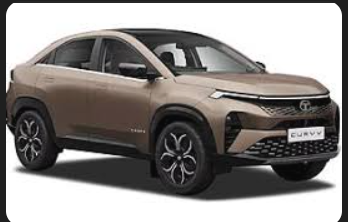

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.ops import roi_align
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from google.colab.patches import cv2_imshow

# Load Pre-trained CNN
cnn_model = models.vgg16(weights="DEFAULT").features.eval()

# Define Fast R-CNN Model
class FastRCNN(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super(FastRCNN, self).__init__()
        self.feature_extractor = feature_extractor
        self.roi_align = roi_align
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, feature_map, rois):
        roi_features = self.roi_align(feature_map, rois, output_size=(7, 7))
        roi_features = roi_features.view(roi_features.size(0), -1)
        out = self.fc(roi_features)
        return out

# Generate Region Proposals using Selective Search
def generate_region_proposals(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects[:200]  # Limit to top 200 proposals for efficiency

# Feature Extraction and ROI Pooling
def extract_features(image, rects, transform, cnn_model, device):
    h, w, _ = image.shape
    transformed_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature_map = cnn_model(transformed_image)

    scaled_rects = []
    for x, y, w_rect, h_rect in rects:
        x1 = int(x / w * feature_map.shape[3])  # Scale to feature map dimensions
        y1 = int(y / h * feature_map.shape[2])
        x2 = int((x + w_rect) / w * feature_map.shape[3])
        y2 = int((y + h_rect) / h * feature_map.shape[2])
        scaled_rects.append([0, x1, y1, x2, y2])  # Add batch index

    rois = torch.tensor(scaled_rects, dtype=torch.float32).to(device)
    return feature_map, rois

# Train Classifier
def train_classifier(features, labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    classifier = SVC(kernel="linear", probability=True)
    classifier.fit(features, encoded_labels)
    return classifier, label_encoder

# Object Detection
def detect_objects(image, classifier, label_encoder, rects, features):
    predictions = classifier.predict(features)
    probabilities = classifier.predict_proba(features)
    results = []
    for i, (x, y, w, h) in enumerate(rects):
        label = label_encoder.inverse_transform([predictions[i]])[0]
        confidence = np.max(probabilities[i])
        if confidence > 0.8:  # Confidence threshold
            results.append((label, confidence, (x, y, w, h)))
    return results

# Main Pipeline
def fast_rcnn_pipeline(image_path, labels, transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_model.to(device)

    # Load image
    image = cv2.imread(image_path)
    rects = generate_region_proposals(image)

    # Feature extraction
    feature_map, rois = extract_features(image, rects, transform, cnn_model, device)

    # ROI Align
    roi_features = roi_align(feature_map, rois, output_size=(7, 7))
    features = roi_features.view(roi_features.size(0), -1).cpu().numpy()

    # Split data
    train_features = features[:150]
    test_features = features[150:]
    train_labels = labels[:150]
    test_labels = labels[150:]

    # Train classifier
    classifier, label_encoder = train_classifier(train_features, train_labels)

    # Encode test labels
    test_labels_encoded = label_encoder.transform(test_labels)

    # Evaluate
    predictions = classifier.predict(test_features)
    print(classification_report(test_labels_encoded, predictions, target_names=label_encoder.classes_))

    # Detect objects
    results = detect_objects(image, classifier, label_encoder, rects, features)

    # Display results
    for label, confidence, (x, y, w, h) in results:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"{label}: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2_imshow(image)

# Image Preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Example Usage
image_path = "image.png"  # Replace with your image path
labels = ["car", "bike"] * 100  # Placeholder labels (replace with actual labels)
fast_rcnn_pipeline(image_path, labels, transform)


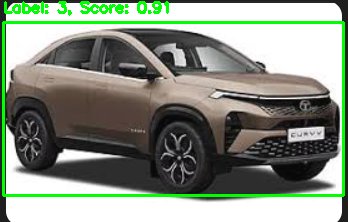

In [ ]:
import cv2
import torch
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from google.colab.patches import cv2_imshow

# Load Pre-trained Faster R-CNN model
def load_faster_rcnn():
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    model.eval()
    return model

# Preprocess the input image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    image_tensor = transform(image_rgb).unsqueeze(0)  # Add batch dimension
    return image, image_tensor

# Run Faster R-CNN for object detection
def run_faster_rcnn(model, image_tensor, confidence_threshold=0.8):
    with torch.no_grad():
        outputs = model(image_tensor)  # Perform inference
    return outputs

# Display results on the image
def display_results(image, outputs, confidence_threshold=0.8):
    boxes = outputs[0]['boxes'].cpu().numpy()  # Bounding boxes
    labels = outputs[0]['labels'].cpu().numpy()  # Class labels
    scores = outputs[0]['scores'].cpu().numpy()  # Confidence scores

    for box, label, score in zip(boxes, labels, scores):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            text = f"Label: {label}, Score: {score:.2f}"
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2_imshow(image)  # Display the image with bounding boxes

# Complete Faster R-CNN Pipeline
def faster_rcnn_pipeline(image_path, confidence_threshold=0.8):
    model = load_faster_rcnn()
    original_image, image_tensor = preprocess_image(image_path)
    outputs = run_faster_rcnn(model, image_tensor, confidence_threshold)
    display_results(original_image, outputs, confidence_threshold)

# Provide the path to your image
image_path = "image.png"  # Replace with the path to your image
faster_rcnn_pipeline(image_path)
